In [1]:
import torch
import pytorch_lightning as pl
import numpy as np
import os
import os.path as osp
from shapeglot.models.my_listener import *
from shapeglot.simple_utils import unpickle_data
import matplotlib.pyplot as plt
from PIL import Image
import hydra
import omegaconf

top_data_dir = 'data/main_data_for_chairs'
img_dir = osp.join(top_data_dir,"images/shapenet/03001627")
data_name = 'game_data.pkl'
game_data, word_to_int, int_to_word, int_to_sn_model, sn_model_to_int, sorted_sn_models = \
    unpickle_data(osp.join(top_data_dir, data_name))
vocab_size=len(int_to_word)


In [2]:
#git: before reduce attention dimension by 2
outputs_top_dir = "outputs"
ver_date_dir = "pretrained"

# Automatically select best ckpt #
best_acc = -1
for file in os.listdir(osp.join(outputs_top_dir, f"checkpoints/{ver_date_dir}")):
    if file[-4:] != "ckpt" or file == "last.ckpt":
        continue
    val_acc = float(file[-9:-5])
    if val_acc > best_acc:
        best_acc = val_acc
        ckpt_path = osp.join(outputs_top_dir, f"checkpoints/{ver_date_dir}/{file}")
#################################

# get hyper parameters #
hparams_path = osp.join(outputs_top_dir,"logs", ver_date_dir, "hparams.yaml")
hparams = omegaconf.OmegaConf.load(hparams_path)
########################

listener = ListenerPN.load_from_checkpoint(ckpt_path, hparams=hparams).cuda()
listener.eval()
for p in listener.parameters():
    p.requires_grad = False

unique geometries in train/test/val 3145 393 393


In [ ]:
trainer = pl.Trainer(gpus=1,
                    checkpoint_callback=False,
                    logger=False)
trainer.test(listener)

In [6]:
test_ds = listener.test_ds
int2sn = int_to_sn_model
sn2int = sn_model_to_int
all_test_chairs = set()
for i in range(len(test_ds)):
    chairs, chairs_idx, targets, padded_token = test_ds[i]
    sn_id1, sn_id2, sn_id3 = int2sn[chairs_idx[0]], int2sn[chairs_idx[1]], int2sn[chairs_idx[2]]
    if sn_id1 not in all_test_chairs:
        all_test_chairs.add(sn_id1)
    if sn_id2 not in all_test_chairs:
        all_test_chairs.add(sn_id2)
    if sn_id3 not in all_test_chairs:
        all_test_chairs.add(sn_id3)

In [7]:
# Extract chairs that exists in shapenet_seg dataset
all_test_chairs = list(all_test_chairs)
test_chairs = []
dir_path = "/home/ubuntu/datasets/full_shapenet_seg/03001627"
for i in all_test_chairs:
    path = osp.join(dir_path, f"{i}.txt")
    if osp.exists(path):
        test_chairs.append(i)

[1204 1752 1193]


(-0.3, 0.3, -0.3, 0.3)

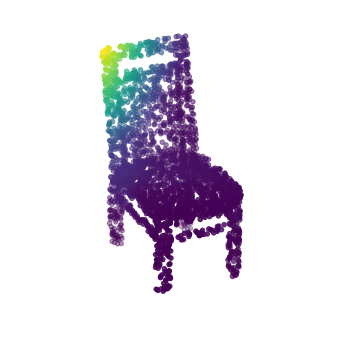

In [138]:
pc = np.loadtxt(osp.join(dir_path,f"{test_chairs[0]}.txt"))
label = pc[:,-1]
pc = pc[:,:3]
idx = np.arange(pc.shape[0])
np.random.shuffle(idx)
pc = pc[idx]
label = label[idx]
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection="3d")

pc_input = torch.tensor(pc).float().unsqueeze(0).cuda()
p_f = listener.pc_encoder(pc_input)

sentence = "back"
token = sentence.split(" ")
token = np.array([word_to_int[token] for token in token])
pad_cnt = 34 - len(token)
padded_token = np.pad(token, (0, pad_cnt), "constant", constant_values=0)
padded_token = torch.tensor(padded_token).unsqueeze(0).cuda()
l_f = listener.language_encoder_attn(padded_token)[0]

attn_f, attn_weight = listener.cross_attn_layers[0](l_f.unsqueeze(1), p_f, p_f)


attn_map = attn_weight.squeeze(0).detach().cpu().numpy()
ax.scatter(pc[:,0], pc[:,2], pc[:,1], c=attn_map)
ax.set_xlim(-0.3,0.3)
ax.set_ylim(-0.3,0.3)
ax.set_zlim(-0.3,0.3)
ax.view_init(elev=25, azim=-25)
ax.axis("off")

array([ 0.10664, -0.12597,  0.04066, ..., -0.13309, -0.12856,  0.13077])

In [62]:
def get_attn_map(sn_id, sentence="leg", threshold=0.5):
     # 12: back |13: seat | 14: leg | 15: arm
    
    ###### Load & break_up pc and label #############
    pc = np.loadtxt(osp.join(dir_path,f"{sn_id}.txt"))
    label = pc[:, -1]
    back_label = (label == 12.)
    seat_label = (label == 13.)
    leg_label = (label == 14.)
    arm_label = (label == 15.)
    
    pc = pc[:, :3]
    #################################################
    
    ########### make network's input         ############
    pc_input = torch.tensor(pc).float().unsqueeze(0).cuda()
    
    token = sentence.split(" ")
    token = np.array([word_to_int[token] for token in token])
    pad_cnt = 34 - len(token)
    padded_token = np.pad(token, (0, pad_cnt), "constant", constant_values=0)
    padded_token = torch.tensor(padded_token).unsqueeze(0).cuda()
    ###################################################
    
    ########### extract point feature & language feature ############
    p_f = listener.pc_encoder(pc_input)
    l_f = listener.language_encoder_attn(padded_token)[0]
    #################################################################
    
    ######## get attention & binary #######
    attn_f, attn_weight = listener.cross_attn_layers[0](l_f.unsqueeze(1), p_f, p_f)
    attn_map = attn_weight.squeeze().detach().cpu().numpy()
    minv = attn_map.min(axis=0)
    maxv = attn_map.max(axis=0)
    attn_map = (attn_map - minv) / (maxv - minv)
    attn_map = np.where(attn_map > threshold, 1, 0)
    ######################################
    
    def get_iou(pred, gt):
        intersect = np.sum(np.logical_and(pred, gt))
        union = np.sum(np.logical_or(pred, gt))
        iou = intersect / (union + 1e-8)
        return iou
    
    back_iou = 100*get_iou(attn_map, back_label) if back_label.sum() > 0 else float("NaN")
    seat_iou = 100*get_iou(attn_map, seat_label) if seat_label.sum() > 0 else float("NaN")
    leg_iou = 100*get_iou(attn_map, leg_label) if leg_label.sum() > 0 else float("NaN")
    arm_iou = 100*get_iou(attn_map, arm_label) if arm_label.sum() > 0 else float("NaN")
    
#     return back_iou, seat_iou, leg_iou, arm_iou
    
    
    fig = plt.figure(figsize=(12,6))

    
    print(attn_map.sum())
    ax = fig.add_subplot(1,2,1, projection="3d")
    ax.scatter(pc[:,0], pc[:,2], pc[:,1], c=attn_map)
    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.3,0.3)
    ax.set_zlim(-0.3,0.3)
    ax.view_init(elev=25, azim=-25)
    ax.axis("off")
    
    ax = fig.add_subplot(1,2,2, projection='3d')
    ax.scatter(pc[:,0], pc[:,2], pc[:,1], c=label)
    ax.set_xlim(-0.3,0.3)
    ax.set_ylim(-0.3,0.3)
    ax.set_zlim(-0.3,0.3)
    ax.view_init(elev=25, azim=-25)
    ax.axis("off")

OSError: /home/ubuntu/datasets/full_shapenet_seg/03001627/453.txt not found.

In [92]:
from math import isnan
IoU = dict(back=[], seat=[], leg=[], arm=[])
for (i, sn_id) in enumerate(test_chairs):
    if i % 100 == 0:
        print(f"{i} finish")
    back, seat, leg, arm = get_attn_map(sn_id, "leg")
    if not isnan(back):
        IoU["back"].append(back)
    if not isnan(seat):
        IoU["seat"].append(seat)
    if not isnan(leg):
        IoU["leg"].append(leg)
    if not isnan(arm):
        IoU["arm"].append(arm)

0 finish
100 finish
200 finish
300 finish
400 finish
500 finish
600 finish
700 finish


In [93]:
back_iou = sum(IoU["back"]) / len(IoU["back"])
seat_iou = sum(IoU["seat"]) / len(IoU["seat"])
leg_iou = sum(IoU["leg"]) / len(IoU["leg"])
arm_iou = sum(IoU["arm"]) / len(IoU["arm"])
leg_l = [back_iou, seat_iou, leg_iou, arm_iou]
print(back_iou, seat_iou, leg_iou, arm_iou)

1.3545866483792175 1.4917268861169264 14.93440556398647 0.8375276323682851


In [3]:
def visualize(choice, sentence=None, save=False):
    chairs, chairs_idx, targets, padded_token = listener.test_ds[choice]
    chairs, chairs_idx = chairs.unsqueeze(0), torch.tensor(chairs_idx).unsqueeze(0)
    
    if sentence is not None:
        token = sentence.split(" ")
        token = np.array([word_to_int[token] for token in token])
        pad_cnt = 34 - len(token)
        padded_token = np.pad(token, (0, pad_cnt), "constant", constant_values=0)
    
    padded_token = torch.tensor(padded_token).unsqueeze(0)
    ############ Run the Model ############
    listener.eval()
    outputs = listener(chairs.cuda(), chairs_idx.cuda(), padded_token.cuda())
    #######################################
    
    chairs = chairs[0].cpu().numpy()
    pred = outputs["logits"][0].max(-1)[1].cpu().numpy()
    answer = targets
    attn_map = torch.cat(outputs["attn_weights"][0], 0).cpu().numpy()
    token = padded_token[0].cpu().numpy()

    sentence = [int_to_word[t] for t in token]
    sentence = " ".join([s for s in sentence if s != "<EOS>"])

    ca, cb, cc = chairs_idx[0].tolist()
    ca, cb, cc = int_to_sn_model[ca], int_to_sn_model[cb], int_to_sn_model[cc]
    ca_name, cb_name, cc_name = os.listdir(osp.join(img_dir, ca))[0], \
                                os.listdir(osp.join(img_dir, cb))[0], \
                                os.listdir(osp.join(img_dir, cc))[0]
    ca, cb, cc = osp.join(img_dir, ca, ca_name), osp.join(img_dir, cb, cb_name), osp.join(img_dir, cc, cc_name)
    ca, cb, cc = Image.open(ca), Image.open(cb), Image.open(cc)
    chair_img = [ca, cb, cc]

    total_head = hparams["num_heads"]
    plt.rcParams["image.cmap"]="viridis"
    fig = plt.figure(figsize=(3*6,6*2), facecolor="white")
    fig.suptitle(f"Sentence: \"{sentence}\"\npred: {pred} | answer: {answer}", fontsize=25)
    for i in range(3):
        ax = fig.add_subplot(2,3,i+1, projection="3d")
        ax.scatter(chairs[i,:,0], chairs[i,:,2], chairs[i,:,1], c=attn_map[i,0])
        ax.set_xlim(-0.3,0.3)
        ax.set_ylim(-0.3,0.3)
        ax.set_zlim(-0.3,0.3)
        ax.view_init(elev=25, azim=-25)
        ax.axis("off")
        
        ax = fig.add_subplot(2,3,i+4)
        ax.imshow(chair_img[i])
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    if save:
        plt.savefig()

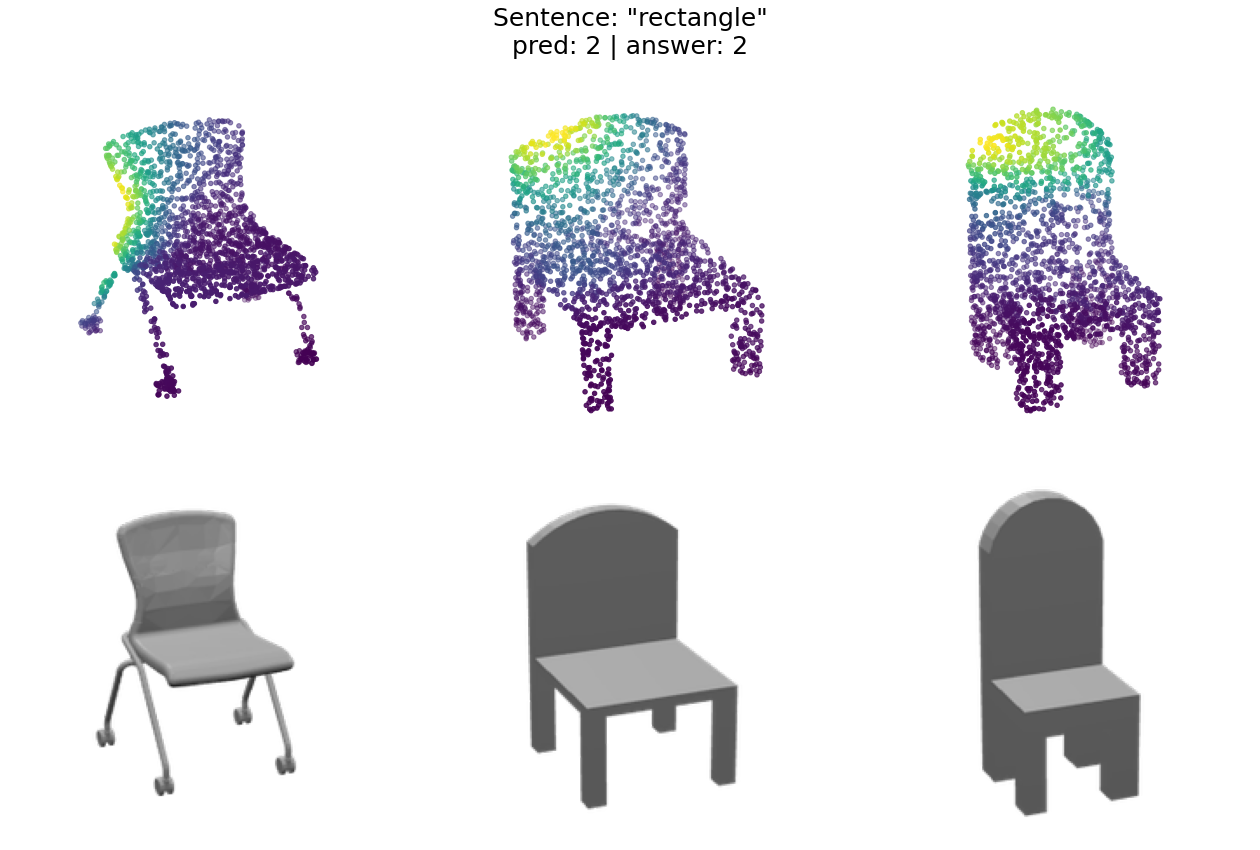

In [21]:
visualize(465, "rectangle")